In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

# Pets revisited (with argumentation)

In [5]:
bs = 64

In [6]:
path = untar_data(URLs.PETS)/'images'

In [7]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [7]:
doc(get_transforms)

In [8]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [13]:
path.ls()

[PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/beagle_67.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/samoyed_14.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/basset_hound_169.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_91.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/British_Shorthair_136.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/Bengal_65.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/saint_bernard_108.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/pug_80.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/boxer_178.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/shiba_inu_158.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/beagle_55.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images/Persian_19.jpg'),
 PosixPath('/home/luan/.fastai/data/oxford-iii

In [14]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [15]:
data = get_data(224, bs, 'zeros')

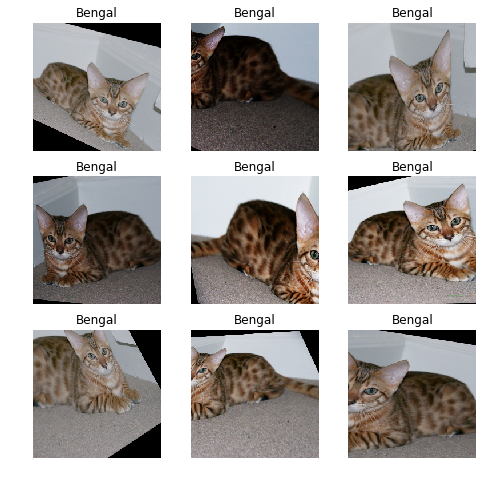

In [16]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [17]:
data = get_data(224, bs)

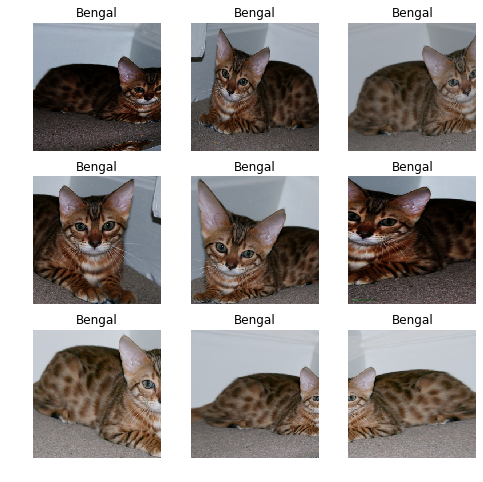

In [18]:
plot_multi(_plot, 3, 3, figsize=(8,8))

# Model

In [19]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics = error_rate, bn_final=True)

In [20]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.482999,1.278838,0.255074,01:04
1,1.471414,0.311547,0.076455,00:23
2,0.925150,0.254901,0.066982,00:23


In [21]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(1e-6, 1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.703591,0.272976,0.057510,00:29
1,0.662187,0.254187,0.054127,00:29


In [23]:
data = get_data(352, bs)
learn.data = data

In [24]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.602203,0.238136,0.049391,01:10
1,0.581136,0.241406,0.049391,01:06


In [25]:
learn.save('352')

# Convolution kernel

In [26]:
data = get_data(352, 16)

In [27]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category Bombay

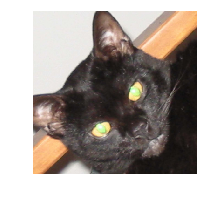

In [30]:
idx=0
x,y = data.valid_ds[idx]
x.show()
y

In [31]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [32]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [33]:
k.shape

torch.Size([1, 3, 3, 3])

In [34]:
t = data.valid_ds[0][0].data
t.shape

torch.Size([3, 352, 352])

In [37]:
data.valid_ds[0]

(Image (3, 352, 352), Category Bombay)

In [38]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [39]:
edge = F.conv2d(t[None], k)

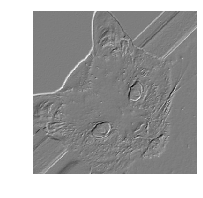

In [43]:
show_image(edge[0])

In [44]:
data.c

37

In [45]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
______________________________________________________________

# Heatmap

In [46]:
m = learn.model.eval();

In [47]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [49]:
from fastai.callbacks.hooks import *